# 1. Data set up


## 1.1 Load Data

Please upload both datasets (any file format is ok) to your google drive, and load the datasets through google drive file id in your code. If you want to use Jupyter, please submit all the dataset in an additional zip file.




In [ ]:
!pip install scikit-learn-extra

     |████████████████████████████████| 1.7MB 2.9MB/s 
     |████████████████████████████████| 22.3MB 1.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import os
import pickle
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from numpy import asarray
from matplotlib.ticker import FixedLocator, FixedFormatter
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn import metrics
from skimage.filters import prewitt_h,prewitt_v
import scipy.cluster.hierarchy as shc

from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import complete, dendrogram
from sklearn_extra.cluster import KMedoids


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Dataset 1

In [ ]:
## download numpy array data converted from Yale face image datasets
##  X.npy and y.npy
id='1pmrucfE1Nct6cPLiv5TFIXvgqoJF2NGN'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('X.npy')
id='1Iy_As6ttEp__k3oBW2se5IJ2LoVeHVRN'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('y.npy')

## load yale face array data
X= np.load('X.npy',allow_pickle=True)
y= np.load('y.npy',allow_pickle=True)

In [ ]:
print('Cropped Yale face image files dataset dimensions:',X.shape)

Cropped Yale face image files dataset dimensions: (640, 192, 168)


In [ ]:
## normalize X to 0-1
X=X/255.0

In [ ]:
## Extract edge features from image data using prewitt
## prewitt_h() extracting horizontal edges from image
## prewitt_v() extracting vertical edges from image
##
X_prewitt_h = []
X_prewitt_v = []
for i in range(X.shape[0]):
  X_prewitt_h.append ( prewitt_h(X[i]))
  X_prewitt_v.append(prewitt_v(X[i]))

X_prewitt_h = np.asarray(X_prewitt_h)
X_prewitt_h2 = X_prewitt_h.reshape(640,-1)

In [ ]:
## applying Principal Component Analysis and transform the data X 
## to X_pca
X = X.reshape(640,-1)
pca = PCA(n_components=0.99,whiten= True).fit(X)
X_pca = pca.transform(X)
print('After PCA, reduced dimension of dataset:',X_pca.shape)

After PCA, reduced dimension of dataset: (640, 137)


In [ ]:
## The first two PCA components extracted 37.8% and 35% of the all feautres variance
## 
pca.explained_variance_ratio_[:2]

array([0.37837947, 0.35036038])

<function matplotlib.pyplot.show>

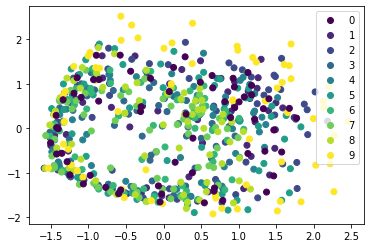

In [ ]:
classes = range(11)

scatter = plt.scatter(X_pca[:,0],X_pca[:,1],c=y)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show

### Dataset 2

File is accessed and downloaded by its google id. For the Amazon review data for books, each line has a format: <br>
***feature:< count > .... feature:< count > #label#:< label >***

Labels which are ratings given by the user while reviewing a book are extracted and used as a ground truth values for evaluating cluster performance. There are 4 labels in the dataset (1.0, 2.0, 4.0 and 5.0). Input file is uploaded on the Google Drive and read in the code using file ID. To get the raw review text from input file, features having count greater than 1 are repeated that many number of times. Features containing more than one word joined by an underscore are split. Raw data is tokenised, cleaned by removing punctuations and stop words and then stemmed and vectorized using feature extractors like TF-IDF, Hashing and Count Vectorizers. Parameters (max_df=0.8 and min_df=0.005) for TF-IDF and CountVectorizer are tuned to get reduced set of features.




In [ ]:
file_name = 'amazon_book.review'
id='1298lorudNIcztXAeEPeL8-93ZNpa92Pn'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(file_name)

In [ ]:
y_d2=[]
reviews = []
with open(file_name,'r',encoding='utf-8') as file:
  for line in file:
    raw_text = ''
    text, label = line.strip().split('#label#:')
    for word in text.strip().split(' '):
      term, freq = word.split(':')
      raw_text = raw_text + (term+' ')* int(freq) 
    reviews.append(raw_text.replace("_", " "))
    y_d2.append(float(label))

In [ ]:
print('Total number of reviews: ', len(reviews))
print(reviews[3])

Total number of reviews:  5501
it would count system continually found simple k-0 by you outdated knew and even book has original thorpe's most of contains no theory of of isn't a this this by the be surpassed powerful and that the even no you you you the popular popular outdated info outdated really even if i found didn't it has been system presented this book terrible one you didn't powerful bad bland but giving you contains surpassed by feeling that the unsettling terrible info better k-0 elsewhere eg explains simple found i it explains but but and and and practice of book isn't explains the has been k-0 system book book book feeling presented in one unsettling feeling more powerful get you continually continually get it it is giving this information in card counting if i knew bad information eg ed bland isn't thorpe's original in the been surpassed unsettling learned elsewhere the theory most card learned personally i personally practice of card counting but one it and more of this

In [ ]:
### data preprocessing - Tokenising and stemming
stemmer = SnowballStemmer("english")
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation and stop words)
    for token in tokens:
        if (re.search('[a-zA-Z]', token) and token not in stop_words):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    #print(stems[:20])
    return stems

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



**Feature Extraction using TF-IDF, Hashing and CountVectorizer**


In [ ]:
### TfidfVectorizer with stemming

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.005 , max_features=50000,
                                  stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)

print('tfidf_matrix.shape: ', tfidf_matrix.shape)
print('vocabulary size:', len(tfidf_vectorizer.vocabulary_))
dist_tfidf = 1 - cosine_similarity(tfidf_matrix)

X_tfidf = tfidf_matrix


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


tfidf_matrix.shape:  (5501, 2801)
vocabulary size: 2801


In [ ]:
# ### HashingVectorizer

# hashVectorizer = HashingVectorizer(stop_words='english', 
#                                alternate_sign=False, 
#                                tokenizer=tokenize_and_stem)
# hashing_matrix = hashVectorizer.fit_transform(reviews)

# print('hashing_matrix.shape: ', hashing_matrix.shape)
# dist_hashing = 1 - cosine_similarity(hashing_matrix)


In [ ]:
### CountVectorizer

vect_count = CountVectorizer(stop_words="english" ,max_df=0.8, min_df=0.005,
                             tokenizer=tokenize_and_stem)
count_matrix = vect_count.fit_transform(reviews)

print('count_matrix.shape: ', count_matrix.shape)
print('vocabulary size:', len(vect_count.get_feature_names()))
#print(vect_count.get_feature_names()[100:130])

X_cv = count_matrix


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


count_matrix.shape:  (5501, 1847)
vocabulary size: 1847


In [ ]:
dist_count = 1 - cosine_similarity(count_matrix)

linkage_matrix_cv = complete(dist_count) #define the linkage_matrix using ward clustering pre-computed distances
linkage_matrix_cv.shape

(5500, 4)

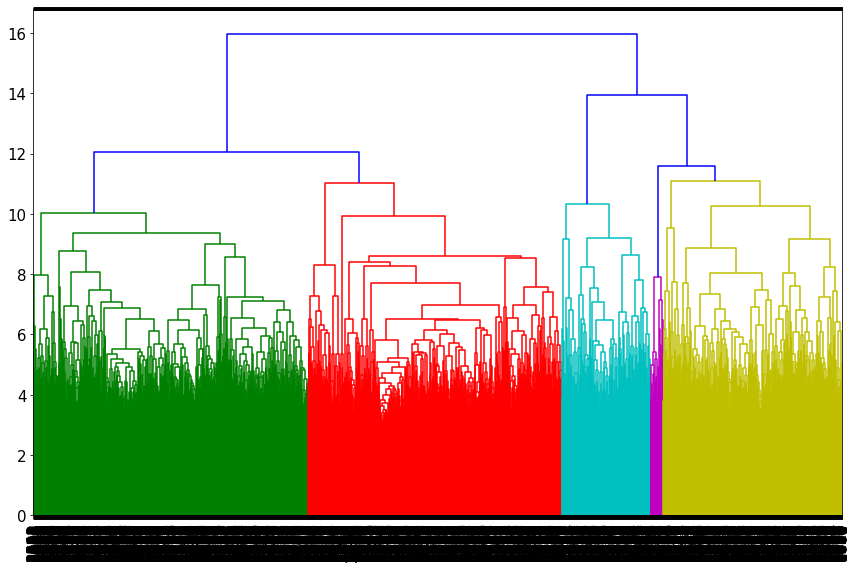

In [ ]:

fig, ax = plt.subplots(figsize=(12, 8)) # set size
ax = dendrogram(linkage_matrix_cv, orientation="top");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off',
    labelsize=15
    )
plt.tick_params(\
    axis= 'y',          # changes apply to the y-axis
    labelsize=15
    )

plt.tight_layout() #show plot with tight layout

#save figure as ward_clusters
plt.savefig('ward_clusters.png', dpi=200) 



---


# 2. K-means Clustering

## 2.1 Dataset 1

### Train K-means clustering

**Choosing Opitmal Feature Extraction**

In [ ]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
y_pred = kmeans.predict(X)

In [ ]:
kmeans_pca = KMeans(n_clusters=10)
kmeans_pca.fit(X_pca)
y_pred_pca = kmeans_pca.predict(X_pca)

In [ ]:
kmeans_edge = KMeans(n_clusters=10)
kmeans_edge.fit(X_prewitt_h2)
y_pred_edge = kmeans_edge.predict(X_prewitt_h2)

In [ ]:
print('\n\nfowlkes_mallows_score for raw data:',fowlkes_mallows_score(y,y_pred))
print('fowlkes_mallows_score for PCA data:',fowlkes_mallows_score(y,y_pred_pca))
print('fowlkes_mallows_score for data with edge feature extraction:',fowlkes_mallows_score(y,y_pred_edge))



fowlkes_mallows_score for raw data: 0.12202810007969392
fowlkes_mallows_score for PCA data: 0.2216646270617412
fowlkes_mallows_score for data with edge feature extraction: 0.35512509886216165


We tried applying kmeans containing all parameters constant on different feature extraction dataset (raw data, PCA reduced-dimention data, data of edge feature extraction with prewitt). Evaluate the clustering results using extrinsic evaluation pairwise metric fowlkes_mallows, which compare the similarities between two clustering, one clustering from predicted labels, the other one with ground truth labels. Data with edge feature extraction achieved the highest performance. Therefore, we will use this data set with feature extraction as our input data to clustering algorithms.

**Choosing Optimal K**

In [ ]:
## Choosing optimal k through ploting inertia through different k values
## and detect the elbow.

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_prewitt_h2)
                for k in range(8,13)]
inertias = [model.inertia_ for model in kmeans_per_k]

[33027.111337366434, 32324.539046302736, 31617.303357122582, 30462.24759424574, 29914.711063013176]


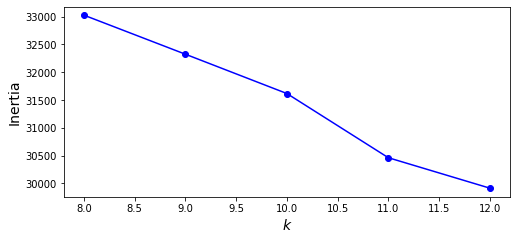

In [ ]:
print(inertias)

plt.figure(figsize=(8, 3.5))
plt.plot(range(8, 13), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [ ]:
## A silhouette score of a model is a mean silhouette score for all points

## The Silhouette Coefficient for a sample is (b - a) / max(a, b)
## a: mean intra-cluster distance  and b: the mean nearest-cluster distance 
## its value ranges from -1 to 1. 
## Negative values indicates that mean nearest-cluster distance < mean intra cluster distance.
##  

silhouette_scores = [silhouette_score(X_prewitt_h2, model.labels_)
                     for model in kmeans_per_k]

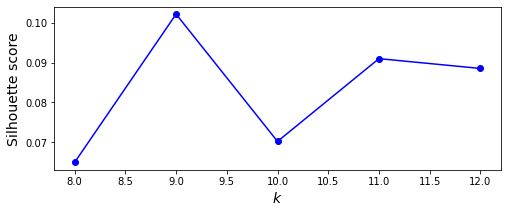

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(8, 13), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

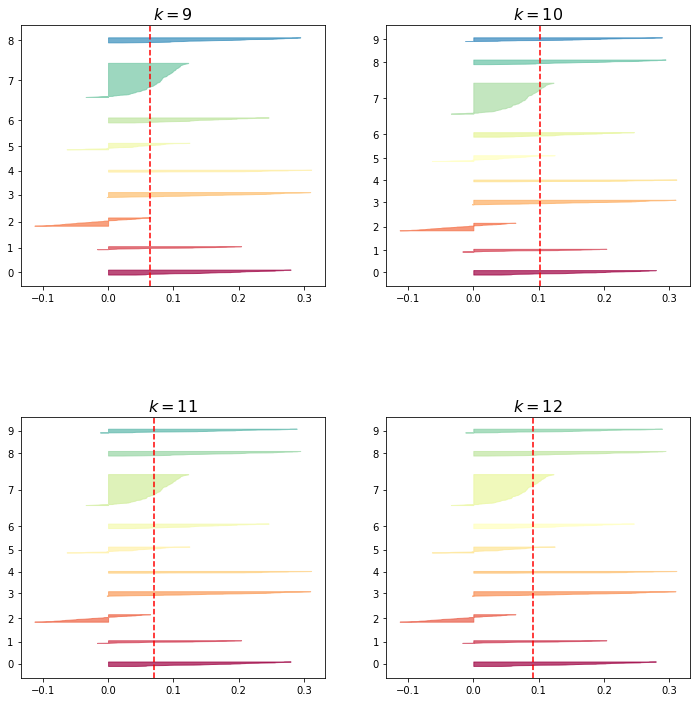

In [ ]:
plt.figure(figsize=(12, 12))

for k in (9,10,11,12):
    plt.subplot(2, 2, k - 8)
    plt.subplots_adjust(hspace=0.5)
    
    y_pred = kmeans_per_k[k - 9].labels_
    silhouette_coefficients = silhouette_samples(X_prewitt_h2, y_pred_edge)

    padding = 5000 // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred_edge == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    # if k in (3, 7):
    #     plt.ylabel("Cluster")
    
    # if k in (3, 4, 5, 6, 7, 8, 9):
    #     plt.gca().set_xticks([-0.01, 0, 0.02, 0.04, 0.06, 0.08])
    #     plt.xlabel("Silhouette Coefficient")
    # else:
    #     plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 9], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

In [ ]:
kmeans = KMeans(n_clusters=11)
kmeans.fit(X_prewitt_h2)
y_pred = kmeans.predict(X_prewitt_h2)

**Second Similarity Measure**

Applying a different similarity measure instead of Euclidean distance.
Using cosine distance metric in KMedoids.

In [ ]:
## Applying a different similarity measure instead of Euclidean distance.
## Using cosine distance metric in KMedoids()

## K-means attempts to minimize the total squared error, while k-medoids minimizes 
## the sum of dissimilarities between points labeled 
## to be in a cluster and a point designated as the center of that cluster. 

kmedoids = KMedoids(n_clusters=11, metric='cosine').fit(X_prewitt_h2)
y_pred_cosine = kmedoids.labels_

### First evaluation

**Justification to choose Fowlkes-Mallow as one of evalution metric**

Fowlkes-Mallow score is a pair-wise measure. For each pair of data points Xi,Xj, yi,yj are ground truth labels, yi_pred,yj_pred are predicint clustering labels.
TP = {yi=yj, yi_pred=yj_prid}
FN = {yi=yj, yi_pred!=yi_pred}
FP = {yi!=yj, yi_pred=yj_pred}
TN = {yi!=yj, yi_pred != yj_pred}

precision = TP/(TP+FP)
recall = TP/(TP+FN)
And then fowlkes-Mallow is a geometric mean of precision and recall. The range is 0 to 1. When the value is equal to 1, it indicates exactly the same two clusterings.

It is a metric to measure the similarity of two clusterings. In our study, we already know the labels for all images. Therefore the more similar our clustering is to the ground truth labels clustering, the better the clustering performance.

In [ ]:
## Cluster size of each clustering model:
print('Cluster size for KMeans Euclidean distance:', np.bincount(y_pred))
print('Cluster size for KMedoids cosine distance:',np.bincount(y_pred_cosine))

Cluster size for KMeans Euclidean distance: [ 12  55 273  36  30  39  42  35  41  42  35]
Cluster size for KMedoids cosine distance: [59 58 78 70 54 63 40 49 63 40 66]


In [ ]:
## Confusion Matrix and Fowlkes_mallows_score

print('\nConfusion matrix for model kmeans:\n',confusion_matrix(y,y_pred_edge))
print('fowlkes_mallows_score for model kmeans:',fowlkes_mallows_score(y,y_pred_edge))
#print('fowlkes_mallows_score for data with edge feature extraction:',fowlkes_mallows_score(y,y_pred_edge))


Confusion matrix for model kmeans:
 [[ 0  0  0  0  0  0  0  0  0  0  0]
 [41  0  4  0  0  0  0 19  0  0  0]
 [ 0  0  0 41  0  0  0 23  0  0  0]
 [ 0  0 22  0  0 24  0 18  0  0  0]
 [ 0  0  0  0  0  0  0 64  0  0  0]
 [ 0 25  0  0 16  0  0 23  0  0  0]
 [ 0  0 11  0  0  0  0 19  0 34  0]
 [ 0  0  0  0  0  0  0 64  0  0  0]
 [ 0  0  6  0  0  0 41 17  0  0  0]
 [ 0  0  5  0  0  0  0 17 42  0  0]
 [ 0  0 20  0  0 29  0 15  0  0  0]]
fowlkes_mallows_score for model kmeans: 0.35512509886216165


In [ ]:
print('Confusion matrix for kmedoids with cosine metric:\n',confusion_matrix(y,y_pred_cosine))
print('\n\nfowlkes_mallows_score is:',fowlkes_mallows_score(y,y_pred_cosine))

Confusion matrix for kmedoids with cosine metric:
 [[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 3 45 13  0  1  0  0  0  2  0  0]
 [ 8  0  6  0  0 50  0  0  0  0  0]
 [ 8  1  8  0 10  1  0 36  0  0  0]
 [ 0  0  1 55  0  0  0  0  8  0  0]
 [ 4  4  3  0  3 12  1 10  7  0 20]
 [15  0 16  0  0  0  0  0  0 33  0]
 [ 2  2  9 15  0  0  3  0 22  0 11]
 [ 8  6  8  0 17  0 15  2  1  7  0]
 [ 0  0  5  0  1  0  0  0 23  0 35]
 [11  0  9  0 22  0 21  1  0  0  0]]


fowlkes_mallows_score is: 0.4002267038488114


### Second evaluation

In [ ]:
## Silhouette score

print('silhouette score for the KMeans Clustering:',silhouette_score(X_prewitt_h2,y_pred))
print('silhouette score for the KMedoids Clustering:',silhouette_score(X_prewitt_h2,y_pred_cosine))



silhouette score for the KMeans Clustering: 0.07548605931203575
silhouette score for the KMedoids Clustering: 0.05026862742293029


## 2.2 Dataset 2

### Train K-means clustering

First, K-means algorithm is applied on pre-processed input data with TF_IDF feature extractor. As K-means only uses Euclidean distance, K-Medoids algorithm is used to evaluate distance measures like Manhattan, cosine and Euclidean for multiple values of K. <br><br>
K-means used concept of centroid, which is a mean of a group of points, whereas K-medoids is based on medoid, which is a most representative point for a group of points and hence various distance measures can be applied. <br><br>


In [ ]:
# kmeans_per_k_tfidf = [KMeans(n_clusters=k).fit(X_tfidf)
#                 for k in range(2, 5)]
# kmeans_per_k_cv = [KMeans(n_clusters=k).fit(X_cv)
#                 for k in range(2, 5)]
# kmeans_per_k_tfidf_pca = [KMeans(n_clusters=k).fit(X_tfidf_pca)
#                 for k in range(2, 5)]
# kmeans_per_k_cv_pca = [KMeans(n_clusters=k).fit(X_cv_pca)
#                 for k in range(2, 5)]

# K-means
kmeans_per_k_cv = [KMeans(n_clusters=k).fit(X_tfidf)
                 for k in range(2, 8)]

# K-medoids - Manhattan
kMedoid_per_k_cv_s_m = [KMedoids(n_clusters=k, init='k-medoids++', metric='manhattan').fit(X_tfidf)
                 for k in range(2, 8)]

# K-medoids - Cosine
kMedoid_per_k_cv_s_c = [KMedoids(n_clusters=k, init='k-medoids++', metric='cosine').fit(X_tfidf)
                 for k in range(2, 8)]

# K-medoids - Euclidean
kMedoid_per_k_cv_s_e = [KMedoids(n_clusters=k, init='k-medoids++', metric='euclidean').fit(X_tfidf)
                 for k in range(2, 8)]


**Choosing optimal K value:**

For elbow method to choose K, intertias are plotted for various values of k for K-means and K-medoids with 3 similarity measures.
No visible elbow observed.

In [ ]:
# K-means
inertias_cv = [model.inertia_ for model in kmeans_per_k_cv]
print(inertias_cv)

# K-medoids - Manhattan
inertias_cv_s_m = [model.inertia_ for model in kMedoid_per_k_cv_s_m]
print(inertias_cv_s_m)

# K-medoids - Cosine
inertias_cv_s_c = [model.inertia_ for model in kMedoid_per_k_cv_s_c]
print(inertias_cv_s_c)

# K-medoids - Euclidean
inertias_cv_s_e = [model.inertia_ for model in kMedoid_per_k_cv_s_e]
print(inertias_cv_s_e)


[5274.757215000207, 5236.27083075027, 5219.180402553116, 5198.870190965196, 5185.221072913581, 5171.748206993055]
[37071.70226467596, 37068.119161541224, 37057.925591439016, 37058.136247544695, 37038.55123147953, 37035.57761719773]
[4965.863789589557, 4855.78897975813, 4917.102608282513, 4836.1465744280995, 4852.317586698238, 4863.3667001568]
[7374.680186179605, 7342.900570572972, 7298.847820019915, 7310.795468636745, 7295.045105154246, 7293.2425317873585]


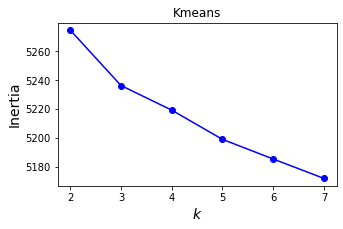

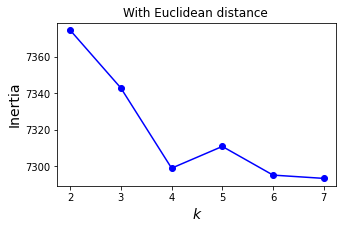

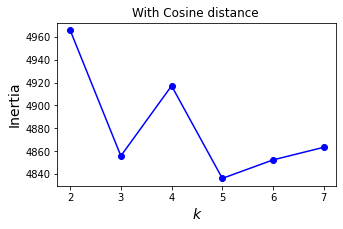

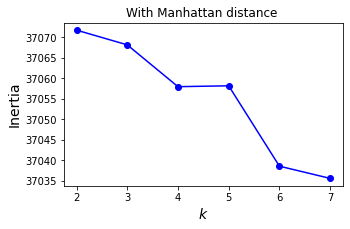

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(2, 8), inertias_cv, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.title("Kmeans")
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(range(2, 8), inertias_cv_s_e, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.title("With Euclidean distance ")
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(range(2, 8), inertias_cv_s_c, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.title("With Cosine distance ")
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(range(2, 8), inertias_cv_s_m, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.title("With Manhattan distance ")
plt.show()


In [ ]:
  print('Confusion matrix for K = 5')
  print('K-Medoids with Euclidean')
  print(confusion_matrix(y_d2,kMedoid_per_k_cv_s_e[3].labels_))
  print('K-Medoids with Cosine')
  print(confusion_matrix(y_d2,kMedoid_per_k_cv_s_c[3].labels_))
  print('K-Medoids with Manhattan')
  print(confusion_matrix(y_d2,kMedoid_per_k_cv_s_m[3].labels_))

Confusion matrix for K = 5
K-Medoids with Euclidean
[[  0   0   0   0   0   0]
 [ 78 543 352 135 278   0]
 [ 79 487 397 155 282   0]
 [  0   0   0   0   0   0]
 [106 446 353 121 355   0]
 [105 489 295 103 342   0]]
K-Medoids with Cosine
[[  0   0   0   0   0   0]
 [357 241 197 157 434   0]
 [324 305 193 192 386   0]
 [  0   0   0   0   0   0]
 [257 318 244 252 310   0]
 [281 307 227 166 353   0]]
K-Medoids with Manhattan
[[   0    0    0    0    0    0]
 [   0    0    0    0 1386    0]
 [   1    1    0    0 1398    0]
 [   0    0    0    0    0    0]
 [   0    0    0    1 1380    0]
 [   0    0    1    0 1333    0]]


### First evaluation

**Silhouette coefficient:**

For cluster evaluation, silhouette coefficient is selected as an internal measure to evaluate clusters on how well separated the clusters are and how compact clusters are. Value close to 1 indicates good clustering. 

Overall very less Silhouette score is observed for this dataset.

In [ ]:
silhouette_scores_cv = [silhouette_score(X_tfidf, model.labels_) for model in kmeans_per_k_cv]
print(silhouette_scores_cv)

silhouette_scores_cv_s_m = [silhouette_score(X_tfidf, model.labels_) for model in kMedoid_per_k_cv_s_m]
print(silhouette_scores_cv_s_m)

silhouette_scores_cv_s_c = [silhouette_score(X_tfidf, model.labels_) for model in kMedoid_per_k_cv_s_c]
print(silhouette_scores_cv_s_c)

silhouette_scores_cv_s_e = [silhouette_score(X_tfidf, model.labels_) for model in kMedoid_per_k_cv_s_e]
print(silhouette_scores_cv_s_e)


[0.00338067523665978, 0.005995367166668288, 0.005221529633773911, 0.006550876033669888, 0.006145710973532693, 0.007237823444934222]
[-0.010623260912299252, -0.005871171670543009, -0.015903487218663085, -0.01622861986049565, -0.02551311691120572, -0.023248428926587766]
[0.002948439526663072, 0.005339660305936627, 0.0010616381726725704, 0.001234552002271102, 0.0018290238067025372, 0.0055688320775330764]
[0.0011700883771904784, 0.0011647116143618053, 0.005048137310683891, 0.0014171758292128068, 0.001382747499490244, 0.0008855580285159615]


In [ ]:
for (i, score) in enumerate(silhouette_scores_cv_s_e, start=2):
    print('k=',i, 'silhouette_score: ',score)

k= 2 silhouette_score:  0.0011700883771904784
k= 3 silhouette_score:  0.0011647116143618053
k= 4 silhouette_score:  0.005048137310683891
k= 5 silhouette_score:  0.0014171758292128068
k= 6 silhouette_score:  0.001382747499490244
k= 7 silhouette_score:  0.0008855580285159615


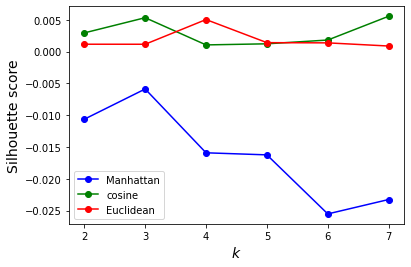

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 8), silhouette_scores_cv_s_m, "bo-", label='Manhattan')
plt.plot(range(2, 8), silhouette_scores_cv_s_c, "go-", label='cosine')
plt.plot(range(2, 8), silhouette_scores_cv_s_e, "ro-", label='Euclidean')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.legend()
plt.show()


### Second evaluation 

**Fowlkes-Mallows score:**

Fowlkes-Mallows score is a pair-wise measure to measure the similarity of two clusterings. It is a geometric mean of precision and recall. The range is 0 to 1. Value close to 1 indicates two clusterings are equal. <br>
When the value is equal to 1, it indicates exactly the same two clusterings.

As the ground truth labels are known for the amazon review dataset, we can measure the performance of clusters labels genearted by our model with the actual labels.

In [ ]:
fm_scores_cv_s_m = [fowlkes_mallows_score(y_d2, model.labels_) for model in kMedoid_per_k_cv_s_m]
print(fm_scores_cv_s_m)
fm_scores_cv_s_c = [fowlkes_mallows_score(y_d2, model.labels_) for model in kMedoid_per_k_cv_s_c]
print(fm_scores_cv_s_c)
fm_scores_cv_s_e = [fowlkes_mallows_score(y_d2, model.labels_) for model in kMedoid_per_k_cv_s_e]
print(fm_scores_cv_s_e)

[0.4998509270491288, 0.49976194663335444, 0.4996765057858927, 0.4995797868085477, 0.49657945657634506, 0.4993984209352835]
[0.39688706482175024, 0.33980512162824666, 0.303469711976913, 0.232665428666698, 0.2518058539465707, 0.2488214373462548]
[0.3583001804535525, 0.2959890418322955, 0.301451980622218, 0.2553608513277042, 0.23863151902486887, 0.21082787534602213]


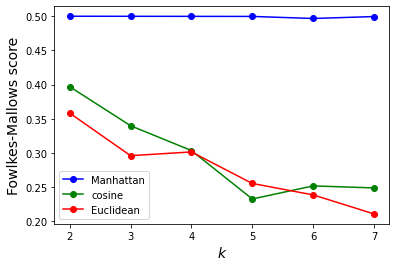

In [ ]:

plt.figure(figsize=(6, 4))
plt.plot(range(2, 8), fm_scores_cv_s_m, "bo-", label='Manhattan')
plt.plot(range(2, 8), fm_scores_cv_s_c, "go-", label='cosine')
plt.plot(range(2, 8), fm_scores_cv_s_e, "ro-", label='Euclidean')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Fowlkes-Mallows score", fontsize=14)
plt.legend()
plt.show()



---


# 3. Hierachical Clustering

## 3.1 Dataset 1

### Train Hierarchical clustering 

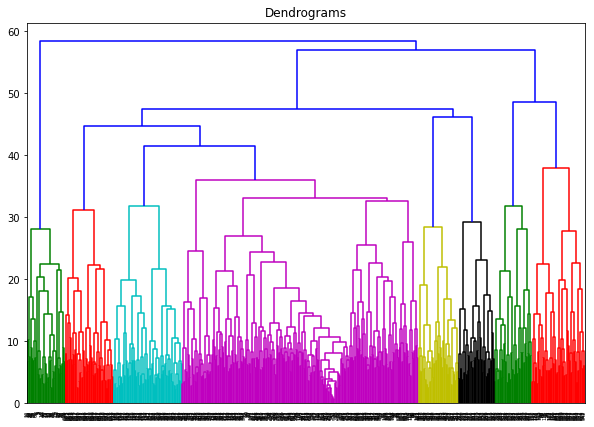

In [ ]:
## Plot hierarchical clustering dendrogram for edge feature extracted data.

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_prewitt_h2, method='ward'))

Train hierarchical clustering applying different distance metrics. Evaluating single, average, complete linkage, and select the best distance metrics based on evaluation.

In [ ]:
## Applying different distance metrics: single, average, complete linkage
## choose the best distance metrics based on evaluation.


cluster_single = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='single')  
y_pred_hier_s = cluster_single.fit_predict(X_prewitt_h2)

cluster_average = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='average')  
y_pred_hier_a = cluster_average.fit_predict(X_prewitt_h2)

cluster_complete = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='complete')  
y_pred_hier_c = cluster_complete.fit_predict(X_prewitt_h2)




In [ ]:
## Check Fowlkes-Mallows score for each model.
print('average-linkage fowlkes_mallows_score:',fowlkes_mallows_score(y,y_pred_hier_a))
print('single-linkage fowlkes_mallows_score:',fowlkes_mallows_score(y,y_pred_hier_s))
print('complete-linkage fowlkes_mallows_score:',fowlkes_mallows_score(y,y_pred_hier_c))



average-linkage fowlkes_mallows_score: 0.31580455671378205
single-linkage fowlkes_mallows_score: 0.30656246339405196
complete-linkage fowlkes_mallows_score: 0.2590844904063216


In [ ]:
### Check clustering size for each model.

print('average-linkage:',np.bincount(y_pred_hier_a))
print('complete-linkage:',np.bincount(y_pred_hier_c))
print('single-linkage:',np.bincount(y_pred_hier_s))

average-linkage: [ 33  32 534  11  10   1  10   1   7   1]
complete-linkage: [204  41  39 245  11   1  22   1  49  27]
single-linkage: [622   4   6   2   1   1   1   1   1   1]


In [ ]:

cluster_euclidean = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='average')  
y_pred_hier = cluster_euclidean.fit_predict(X_prewitt_h2)

**Selection of Best Cluster Distance Metrics**

From above evaluation of different cluster distance metrics options, measuring clusters distance using minimum distance between any two points of two clusters (single-linkage), the maximum distance between any two points of two clusters(complete-linkage) and average distance between two points from two clusters(average-linkage). The hierachicial model with average-linkage parameter achieved the best performance.

In [ ]:
## Trying other two different similarity measures (cosine, and manhattan distance


cluster_cosine = AgglomerativeClustering(n_clusters=10, affinity='cosine', linkage='average')  
y_pred_hier_cosine = cluster_cosine.fit_predict(X_prewitt_h2)

cluster_manhattan = AgglomerativeClustering(n_clusters=10, affinity='manhattan', linkage='average')  
y_pred_hier_manhattan = cluster_manhattan.fit_predict(X_prewitt_h2)



In [ ]:
### Check clustering size for each model.
## average-linkage with cosine distance outputs a more balanced-size clustering.

print('cosine distance:',np.bincount(y_pred_hier_cosine))
print('manhattan distance:',np.bincount(y_pred_hier_manhattan))

cosine distance: [141  39  54  83  64  64  40  64  45  46]
manhattan distance: [  4  32 543  24  26   1   5   1   3   1]


In [ ]:
## Evaluation of hierarchical clustering (average-linkage,euclidean/cosine/manhattan distance)

print('Confusion Matrix: (average-linkage,educlidean distance):\n',confusion_matrix(y,y_pred_hier))
print('\nFowlkes_mallows_score (average-linkage,educlidean distance):',fowlkes_mallows_score(y,y_pred_hier))


print('\n\nConfusion Matrix of hierarchical clustering (average-linkage,cosine distance):\n',confusion_matrix(y,y_pred_hier_cosine))
print('\nFowlkes_mallows_score (average-linkage,cosine distance):',fowlkes_mallows_score(y,y_pred_hier_cosine))


print('\n\nConfusion Matrix (average-linkage,manhattan distance):\n',confusion_matrix(y,y_pred_hier_manhattan))
print('\nFowlkes_mallows_score (average-linkage,manhattan distance):',fowlkes_mallows_score(y,y_pred_hier_manhattan))

Confusion Matrix: (average-linkage,educlidean distance):
 [[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 57  0  0  0  0  0  7  0  0]
 [ 0  0 62  0  0  1  0  1  0  0  0]
 [ 0  0 64  0  0  0  0  0  0  0  0]
 [ 0  0 64  0  0  0  0  0  0  0  0]
 [ 0  0 63  0  0  0  0  0  0  1  0]
 [ 0 32 22  0  0  0 10  0  0  0  0]
 [ 0  0 64  0  0  0  0  0  0  0  0]
 [ 0  0 64  0  0  0  0  0  0  0  0]
 [ 0  0 64  0  0  0  0  0  0  0  0]
 [33  0 10 11 10  0  0  0  0  0  0]]

Fowlkes_mallows_score (average-linkage,educlidean distance): 0.31580455671378205


Confusion Matrix of hierarchical clustering (average-linkage,cosine distance):
 [[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11  7  0  0  0  0  0  0 46  0]
 [ 0  0  0  0  0 64  0  0  0  0  0]
 [52  5  7  0  0  0  0  0  0  0  0]
 [ 0  3  0 45  0  0 16  0  0  0  0]
 [ 0  0  0  0 64  0  0  0  0  0  0]
 [50  7  7  0  0  0  0  0  0  0  0]
 [ 0  1  1 38  0  0 24  0  0  0  0]
 [ 0  3 16  0  0  0  0  0 45  0  0]
 [ 0  0  0  0  0  0  0 64  0  0  0]
 [39  9 16  0  0  0  

### First evaluation 

In [ ]:
## Homogeneity is a metric to measure the purity of a cluster which only include 
## data points from one cluster.
## From the above confusion matrix, the output of agglomerative clustering with average-linkage 
## and cosine distance illustrates good homogeneity that all clusters only include data points 
## from one class. Therefore, we will use homogeneity to check the purity of these clustering model.
## Homogeneity score ranges from 0 to 1, 1 means perfect homogeneous clustering.

from sklearn.metrics.cluster import homogeneity_score
print('homogeneity score average-linkage,euclidean:',homogeneity_score(y,y_pred_hier))
print('homogeneity sxore average_linkage,cosine:',homogeneity_score(y,y_pred_hier_cosine))


homogeneity score average-linkage,euclidean: 0.1962116649023166
homogeneity sxore average_linkage,cosine: 0.7338103568790822


In [ ]:

print('Fowlkes_mallows_score (average-linkage,educlidean distance):',fowlkes_mallows_score(y,y_pred_hier))
print('Fowlkes_mallows_score (average-linkage,cosine distance):',fowlkes_mallows_score(y,y_pred_hier_cosine))
print('Fowlkes_mallows_score (average-linkage,manhattan distance):',fowlkes_mallows_score(y,y_pred_hier_manhattan))

Fowlkes_mallows_score (average-linkage,educlidean distance): 0.31580455671378205
Fowlkes_mallows_score (average-linkage,cosine distance): 0.6273578785098487
Fowlkes_mallows_score (average-linkage,manhattan distance): 0.3012472950847745


### Second evaluation 

In [ ]:
## Silhouette score

print('silhouette score (euclidean):',silhouette_score(X_prewitt_h2,y_pred_hier))
print('silhouette score (cosine):',silhouette_score(X_prewitt_h2,y_pred_hier_cosine))
print('silhouette score (manhattan):',silhouette_score(X_prewitt_h2,y_pred_hier_manhattan))


silhouette score (euclidean): 0.09500276170757732
silhouette score (cosine): 0.04595073856936624
silhouette score (manhattan): 0.0845254358875692


## 3.2 Dataset 2

### Train Hierarchical clustering 

Agglomerative clustering is applied for all combinations of affinity (euclidean, cosine and manhattan) and linkage (single, average and complete) for k in range 3 to 5.

When Agglomerative was applied on data with TF-IDF vectorisation, all points were getting assigned to a single cluster. We tried data with features extracted using CountVectorizer. But there was not improvement. Agglomerative clustering does not seem to be suitable for sparse data as compared to the partition based clustering. More advanced feature extractors need to be applied before applying this method.

In [ ]:
agg_per_k_c_s = [AgglomerativeClustering(n_clusters=k, affinity='cosine', 
                                     linkage='single').fit(X_cv.toarray())
                for k in range(3, 6)]
agg_per_k_c_a = [AgglomerativeClustering(n_clusters=k, affinity='cosine', 
                                     linkage='average').fit(X_cv.toarray())
                for k in range(3, 6)]
agg_per_k_c_c = [AgglomerativeClustering(n_clusters=k, affinity='cosine', 
                                     linkage='complete').fit(X_cv.toarray())
                for k in range(3, 6)]

agg_per_k_e_s = [AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                     linkage='single').fit(X_cv.toarray())
                for k in range(3, 6)]
agg_per_k_e_a = [AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                     linkage='average').fit(X_cv.toarray())
                for k in range(3, 6)]
agg_per_k_e_c = [AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                     linkage='complete').fit(X_cv.toarray())
                for k in range(3, 6)]

agg_per_k_m_s = [AgglomerativeClustering(n_clusters=k, affinity='manhattan', 
                                     linkage='single').fit(X_cv.toarray())
                for k in range(3, 6)]
agg_per_k_m_a = [AgglomerativeClustering(n_clusters=k, affinity='manhattan', 
                                     linkage='average').fit(X_cv.toarray())
                for k in range(3, 6)]
agg_per_k_m_c = [AgglomerativeClustering(n_clusters=k, affinity='manhattan', 
                                     linkage='complete').fit(X_cv.toarray())
                for k in range(3, 6)]

### First evaluation

Fowlkes-Mallows scores are calculated for all 9 models. <br> 
As almost all points are mapped to a single cluster, all 9 models have similar Fowlkes-Mallows score of 0.49 <br>

affinity=euclidean and linkage=single:
 [0.49975692037346564, 0.49966301179206846, 0.4995713184484913]
affinity=euclidean and linkage=average:
 [0.49975692037346564, 0.49966301179206846, 0.49957065685786184]
affinity=euclidean and linkage=complete:
 [0.499759301233413, 0.4996652607910391, 0.4995713184484913]
affinity=cosine and linkage=single:
 [0.49976551792327545, 0.4996714786117229, 0.4995861380785901]
affinity=cosine and linkage=average:
 [0.49929668356234885, 0.4980118578961285, 0.49682763674761754]
affinity=cosine and linkage=complete:
 [0.4113052863213206, 0.4038307073870394, 0.3960925376892359]
affinity=manhattan and linkage=single:
 [0.4997586398834276, 0.4996645993207537, 0.4995791252179183]
affinity=manhattan and linkage=average:
 [0.4997586398834276, 0.4996645993207537, 0.4995791252179183]
affinity=manhattan and linkage=complete:
 [0.49975692037346564, 0.4996645993207537, 0.4995723769934983]


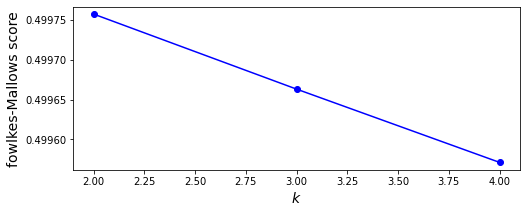

In [ ]:
fowlkes_mallows_e_s = [fowlkes_mallows_score(y_d2, model.labels_)
                     for model in agg_per_k_e_s]
print('affinity=euclidean and linkage=single:\n', fowlkes_mallows_e_s)
fowlkes_mallows_e_a = [fowlkes_mallows_score(y_d2, model.labels_)
                     for model in agg_per_k_e_a]
print('affinity=euclidean and linkage=average:\n', fowlkes_mallows_e_a)
fowlkes_mallows_e_c = [fowlkes_mallows_score(y_d2, model.labels_)
                     for model in agg_per_k_e_c]
print('affinity=euclidean and linkage=complete:\n', fowlkes_mallows_e_c)

fowlkes_mallows_c_s = [fowlkes_mallows_score(y_d2, model.labels_)
                     for model in agg_per_k_c_s]
print('affinity=cosine and linkage=single:\n', fowlkes_mallows_c_s)
fowlkes_mallows_c_a = [fowlkes_mallows_score(y_d2, model.labels_)
                     for model in agg_per_k_c_a]
print('affinity=cosine and linkage=average:\n', fowlkes_mallows_c_a)
fowlkes_mallows_c_c = [fowlkes_mallows_score(y_d2, model.labels_)
                     for model in agg_per_k_c_c]
print('affinity=cosine and linkage=complete:\n', fowlkes_mallows_c_c)

fowlkes_mallows_m_s = [fowlkes_mallows_score(y_d2, model.labels_)
                     for model in agg_per_k_m_s]
print('affinity=manhattan and linkage=single:\n', fowlkes_mallows_m_s)
fowlkes_mallows_m_a = [fowlkes_mallows_score(y_d2, model.labels_)
                     for model in agg_per_k_m_a]
print('affinity=manhattan and linkage=average:\n', fowlkes_mallows_m_a)
fowlkes_mallows_m_c = [fowlkes_mallows_score(y_d2, model.labels_)
                     for model in agg_per_k_m_c]
print('affinity=manhattan and linkage=complete:\n', fowlkes_mallows_m_c)


plt.figure(figsize=(8, 3))
plt.plot(range(2, 5), fowlkes_mallows_e_s, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("fowlkes-Mallows score", fontsize=14)
plt.show() 

### Second evalaution 

**Calinski Harabasz score:**

For Agglomerative clustering evaluation, Calinski Harabasz score is selected as an internal measure which is also known as Variance Ratio Criterion. It is a ratio of sum between clusters dispersion (sum of distances squared) and of within cluster dispersion. Score is higher when clusters are dense and well separated. As almost all points are assigned to a single cluster, score is low for all models. 

affinity=euclidean and linkage=single:
 [0.49975692037346564, 0.49966301179206846, 0.4995713184484913]
affinity=euclidean and linkage=average:
 [0.49975692037346564, 0.49966301179206846, 0.49957065685786184]
affinity=euclidean and linkage=complete:
 [0.499759301233413, 0.4996652607910391, 0.4995713184484913]
affinity=cosine and linkage=single:
 [0.49976551792327545, 0.4996714786117229, 0.4995861380785901]
affinity=cosine and linkage=average:
 [0.49929668356234885, 0.4980118578961285, 0.49682763674761754]
affinity=cosine and linkage=complete:
 [0.4113052863213206, 0.4038307073870394, 0.3960925376892359]
affinity=manhattan and linkage=single:
 [0.4997586398834276, 0.4996645993207537, 0.4995791252179183]
affinity=manhattan and linkage=average:
 [0.4997586398834276, 0.4996645993207537, 0.4995791252179183]
affinity=manhattan and linkage=complete:
 [0.49975692037346564, 0.4996645993207537, 0.4995723769934983]


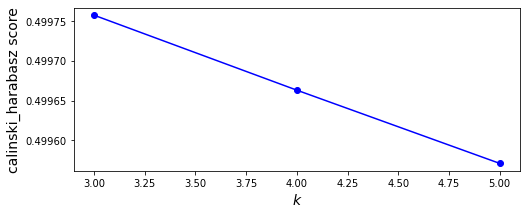

In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

calinski_harabasz_e_s = [calinski_harabasz_score(X_cv.toarray(), model.labels_)
                     for model in agg_per_k_e_s]
print('affinity=euclidean and linkage=single:\n', fowlkes_mallows_e_s)
calinski_harabasz_e_a = [calinski_harabasz_score(X_cv.toarray(), model.labels_)
                     for model in agg_per_k_e_a]
print('affinity=euclidean and linkage=average:\n', fowlkes_mallows_e_a)
calinski_harabasz_e_c = [calinski_harabasz_score(X_cv.toarray(), model.labels_)
                     for model in agg_per_k_e_c]
print('affinity=euclidean and linkage=complete:\n', fowlkes_mallows_e_c)

calinski_harabasz_c_s = [calinski_harabasz_score(X_cv.toarray(), model.labels_)
                     for model in agg_per_k_c_s]
print('affinity=cosine and linkage=single:\n', fowlkes_mallows_c_s)
calinski_harabasz_c_a = [calinski_harabasz_score(X_cv.toarray(), model.labels_)
                     for model in agg_per_k_c_a]
print('affinity=cosine and linkage=average:\n', fowlkes_mallows_c_a)
calinski_harabasz_c_c = [calinski_harabasz_score(X_cv.toarray(), model.labels_)
                     for model in agg_per_k_c_c]
print('affinity=cosine and linkage=complete:\n', fowlkes_mallows_c_c)

calinski_harabasz_m_s = [calinski_harabasz_score(X_cv.toarray(), model.labels_)
                     for model in agg_per_k_m_s]
print('affinity=manhattan and linkage=single:\n', fowlkes_mallows_m_s)
calinski_harabasz_m_a = [calinski_harabasz_score(X_cv.toarray(), model.labels_)
                     for model in agg_per_k_m_a]
print('affinity=manhattan and linkage=average:\n', fowlkes_mallows_m_a)
calinski_harabasz_m_c = [calinski_harabasz_score(X_cv.toarray(), model.labels_)
                     for model in agg_per_k_m_c]
print('affinity=manhattan and linkage=complete:\n', fowlkes_mallows_m_c)


plt.figure(figsize=(8, 3))
plt.plot(range(3, 6), fowlkes_mallows_e_s, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("calinski_harabasz score", fontsize=14)
plt.show() 

In [ ]:
  print(confusion_matrix(y_d2,agg_per_k_m_c[1].labels_))
  print()
  print(confusion_matrix(y_d2,agg_per_k_c_a[1].labels_))
  print()
  print(confusion_matrix(y_d2,agg_per_k_e_s[1].labels_))

[[   0    0    0    0    0    0]
 [1385    1    0    0    0    0]
 [1398    0    1    1    0    0]
 [   0    0    0    0    0    0]
 [1381    0    0    0    0    0]
 [1334    0    0    0    0    0]]

[[   0    0    0    0    0    0]
 [1374    8    2    2    0    0]
 [1394    4    2    0    0    0]
 [   0    0    0    0    0    0]
 [1379    1    0    1    0    0]
 [1333    1    0    0    0    0]]

[[   0    0    0    0    0    0]
 [1386    0    0    0    0    0]
 [1397    1    1    1    0    0]
 [   0    0    0    0    0    0]
 [1381    0    0    0    0    0]
 [1334    0    0    0    0    0]]




---


# 4. Spectral Clustering

## 4.1 Dataset 1

### Train Sprectral clustering 

In [ ]:
## spectral clustering model with default parameters
model = SpectralClustering(n_clusters=10, affinity='nearest_neighbors',
                           assign_labels='kmeans')
model = model.fit(X_prewitt_h2)
labels = model.labels_

print(set(labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [ ]:
params_gama = [0.001, 0.1, 5]
#hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)
spectral_clst = []
for gamma in params_gama:
    model = SpectralClustering(n_clusters=10,affinity='rbf',gamma=gamma)
    model.fit(X_prewitt_h2)
    spectral_clst.append(model)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [ ]:
for model in spectral_clst:
  print(model.labels_[:20])
  print(fowlkes_mallows_score(y,model.labels_))
  print(confusion_matrix(y,model.labels_))

[1 5 5 5 5 5 5 5 5 5 5 5 1 5 5 9 5 5 5 1]
0.3285821192741429
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0 36  0  0  9  0  0  6  0]
 [ 0 17  0  0  0 38  3  0  0  6  0]
 [28 20  0  0  0  0  7  0  0  9  0]
 [ 0 23  0  0  0  0  0 41  0  0  0]
 [ 0 21  0  0  0  0  1  0 41  1  0]
 [ 0  8  0  0 29  0 13  0  0 14  0]
 [ 0 27  0  0  0  0  0 33  0  4  0]
 [ 0 39  0  0  0  0 14  0  0 11  0]
 [ 0 13 39  0  0  0  5  0  0  7  0]
 [27 11  0  0  0  0 14  0  0 12  0]]
[1 9 9 9 9 9 9 9 9 1 9 9 1 9 9 1 9 9 9 1]
0.2989209178460156
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0 64  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  0  0 32  0]
 [ 0 64  0  0  0  0  0  0  0  0  0]
 [ 0 64  0  0  0  0  0  0  0  0  0]
 [ 0 41  0  0 13  0 10  0  0  0  0]
 [ 0 38  0  0  0  0  0  5 21  0  0]
 [ 0 64  0  0  0  0  0  0  0  0  0]
 [ 0 64  0  0  0  0  0  0  0  0  0]
 [41 23  0  0  0  0  0  0  0  0  0]
 [ 0 45  6  3  0 10  0  0  0  0  0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.3086946111149514
[[ 0  0  0  0  0  0  0 

In [ ]:
knn_k = [1,3,5,7]
spectral_clst2 = []
for k in knn_k:
    model = SpectralClustering(n_clusters=10,affinity='nearest_neighbors',n_neighbors=k)
    model.fit(X_prewitt_h2)
    spectral_clst2.append(model)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [ ]:
for model in spectral_clst2:
  print(model.labels_[:20])
  print(fowlkes_mallows_score(y,model.labels_))
  print(confusion_matrix(y,model.labels_))

[0 0 0 2 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 6]
0.2488470568164839
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [51  5  0  0  2  2  3  0  1  0  0]
 [46 12  1  0  0  1  4  0  0  0  0]
 [47  7  1  1  0  1  7  0  0  0  0]
 [53  7  1  0  0  0  2  1  0  0  0]
 [50  4  1  0  0  0  5  0  1  3  0]
 [52  5  2  0  0  0  4  0  1  0  0]
 [48  5  1  0  0  1  8  0  1  0  0]
 [55  5  0  0  0  0  2  0  0  2  0]
 [50  5  0  0  0  0  7  0  2  0  0]
 [50  7  1  0  1  0  3  0  1  1  0]]
[2 7 7 7 7 7 7 7 7 2 7 7 2 2 7 2 7 7 7 2]
0.2888484315407933
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [28  0 36  0  0  0  0  0  0  0  0]
 [ 0  0 37  0  0  0  0 27  0  0  0]
 [ 0  0 64  0  0  0  0  0  0  0  0]
 [ 0  0 51  0 13  0  0  0  0  0  0]
 [ 0  0 51  0  0 13  0  0  0  0  0]
 [ 0  0 24 40  0  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  0 29  0  0]
 [ 0 22 42  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0 35  0  0  0  0]
 [ 0  0 58  0  0  0  0  0  0  6  0]]
[5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5]
0.42193860518858933
[[ 0  0  0  0  0  0  0

From above output, the optimal values we explored is affinity matrix using k-nearest neighbour connectivity matrix and k=7.

In [ ]:
spectral_cluster = SpectralClustering(n_clusters=10,affinity='nearest_neighbors',n_neighbors=7)
spectral_cluster.fit(X_prewitt_h2)

SpectralClustering(affinity='nearest_neighbors', n_clusters=10, n_neighbors=7)

### First evaluation

In [ ]:
print('Fowlkes_mallows score for Spectral Clustering:',fowlkes_mallows_score(y,spectral_cluster.labels_))

Fowlkes_mallows score for Spectral Clustering: 0.4557087848686174


### Second evaluation 

In [ ]:
print('Silhouette score for Spectral Clustering:',silhouette_score(X_prewitt_h2,spectral_cluster.labels_))

Silhouette score for Spectral Clustering: 0.06851481245317936


## 4.2 Dataset 2

### Train Spectral clustering 

Spectral clustering is applied on pre-processed data for all combinations of affinity (nearest_neighbors and rbf) and assign_labels (kmeans and discretize) for k in range 3 to 6.

In [ ]:
spectral_per_k_nn_km = [SpectralClustering(n_clusters=k, affinity='nearest_neighbors', 
                                     assign_labels='kmeans').fit(X_cv)
                       for k in range(3, 7)]               
spectral_per_k_nn_d = [SpectralClustering(n_clusters=k, affinity='nearest_neighbors', 
                                     assign_labels='discretize').fit(X_cv)
                       for k in range(3, 7)]
spectral_per_k_rbf_km = [SpectralClustering(n_clusters=k, affinity='rbf', 
                                     assign_labels='kmeans').fit(X_cv)
                      for k in range(3, 7)]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


### First evaluation 

Silhouette scores are calculated for k=3, k=4, k=5 and k=6 for all  models. <br> 
Highest score of 0.22 is observed for affinity=**nearest_neighbors** and assign_labels=**kmeans** and **k=3** <br>

In [ ]:
print('Silhouette scores for k=3, k=4, k=5, k=6:\n')
silhouette_scores_nn_km = [silhouette_score(X_cv, model.labels_)
                     for model in spectral_per_k_nn_km]
print('affinity=nearest_neighbors and assign_labels=kmeans:\n', silhouette_scores_nn_km)

silhouette_scores_nn_d = [silhouette_score(X_cv, model.labels_)
                     for model in spectral_per_k_nn_d]
print('affinity=nearest_neighbors and assign_labels=discretize:\n', silhouette_scores_nn_d)

silhouette_scores_rbf_km = [silhouette_score(X_cv, model.labels_)
                     for model in spectral_per_k_rbf_km]
print('affinity=rbf and assign_labels=kmeans:\n', silhouette_scores_rbf_km)


Silhouette scores for k=3, k=4, k=5, k=6:

affinity=nearest_neighbors and assign_labels=kmeans:
 [0.22560692999325607, 0.18704034403105335, 0.06555525428606894, 0.0514866720508495]
affinity=nearest_neighbors and assign_labels=discretize:
 [0.11356798546792779, 0.06218951480627814, 0.03131399727158445, -0.0008140284278413491]
affinity=rbf and assign_labels=kmeans:
 [0.02958544773745351, 0.01573127482991458, 0.008249445169180861, 0.006390655812028088]


### Second evaluation 

Fowlkes_Mallows scores are calculated for k=3, k=4, k=5 and k=6 for all models. <br> 
Highest score of 0.49 is observed for affinity=**rbf** and assign_labels=**kmeans** and **k=3** <br>


In [ ]:
print('Fowlkes_Mallows scores for k=3, k=4, k=5, k=6:\n')
fowlkes_mallows_nn_km = [fowlkes_mallows_score(y_d2, model.labels_)
                     for model in spectral_per_k_nn_km]
print('affinity=nearest_neighbors and assign_labels=kmeans:\n', fowlkes_mallows_nn_km)
fowlkes_mallows_nn_d = [fowlkes_mallows_score(y_d2, model.labels_)
                     for model in spectral_per_k_nn_d]
print('affinity=nearest_neighbors and assign_labels=discretize:\n', fowlkes_mallows_nn_d)

fowlkes_mallows_rbf_km = [fowlkes_mallows_score(y_d2, model.labels_)
                     for model in spectral_per_k_rbf_km]
print('affinity=rbf and assign_labels=kmeans:\n', fowlkes_mallows_rbf_km)

Fowlkes_Mallows scores for k=3, k=4, k=5, k=6:

affinity=nearest_neighbors and assign_labels=kmeans:
 [0.45595543583927706, 0.45498273491254954, 0.38237946323127364, 0.3775559231236367]
affinity=nearest_neighbors and assign_labels=discretize:
 [0.41086906060502426, 0.403783990262403, 0.33167130400822226, 0.3258586200517281]
affinity=rbf and assign_labels=kmeans:
 [0.4993042298120321, 0.49922074647973896, 0.49902337121675977, 0.4991239392035275]


In [ ]:

print(confusion_matrix(y_d2,spectral_per_k_nn_km[0].labels_))
print(confusion_matrix(y_d2,spectral_per_k_nn_d[0].labels_))


[[   0    0    0    0    0]
 [1268   98   20    0    0]
 [1250  135   15    0    0]
 [1224  139   18    0    0]
 [1254   61   19    0    0]]
[[   0    0    0    0    0]
 [ 205 1136   45    0    0]
 [ 286 1083   31    0    0]
 [ 278 1063   40    0    0]
 [ 158 1129   47    0    0]]
